In [16]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from pygam import LogisticGAM
from sklearn.metrics import accuracy_score
from sklearn import tree
import pydotplus
import collections
from IPython.display import Image, display

%matplotlib inline

import os     
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [2]:
df = pd.read_csv("../data/Spam.txt")
df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [3]:
predictors = ['word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_free', 
              'word_freq_business', 'word_freq_hpl', 'word_freq_hp', 'word_freq_george', 'word_freq_1999',
              'word_freq_re', 'word_freq_edu', 'char_freq_!', 'char_freq_$', 
              'capital_run_length_longest', 'capital_run_length_total']
X = df[predictors].values
y = df['spam'].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=3065, random_state=30)

C:\Python64\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
ls = sm.Logit(y_train, sm.add_constant(X_train)).fit(disp=False)
r = 1-accuracy_score(y_train, np.round(ls.predict(sm.add_constant(X_train))))
print('Training error', r)
r = 1-accuracy_score(y_test, np.round(ls.predict(sm.add_constant(X_test))))
print('Test error', r)

Training error 0.08678629690048945
Test error 0.08919270833333337


In [6]:
X_train_log = np.log(X_train+0.1)
X_test_log = np.log(X_test+0.1)
gam = LogisticGAM(lam=[400, 20, 5.5, 7, 14, 3, 1, 1, 0.08, 2, 1, 1, 8, 1, 4, 3]).fit(X_train_log, y_train)

In [7]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     64.2218
Link Function:                        LogitLink Log Likelihood:                                  -437.4299
Number of Samples:                         3065 AIC:                                             1003.3033
                                                AICc:                                            1006.1839
                                                UBRE:                                               2.3441
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.7879
Feature Function                  Lam

C:\Python64\lib\site-packages\ipykernel\__main__.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  if __name__ == '__main__':


In [8]:
print('Training error', 1-gam.accuracy(X_train_log, y_train))
print('Test error', 1-gam.accuracy(X_test_log, y_test))

Training error 0.04893964110929849
Test error 0.064453125


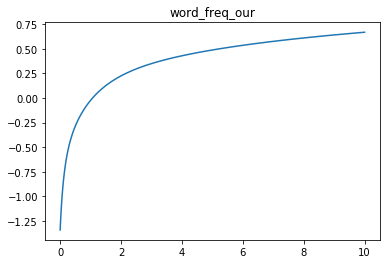

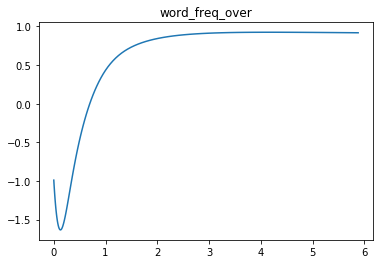

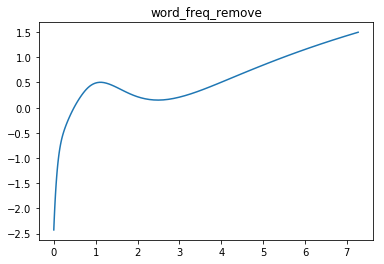

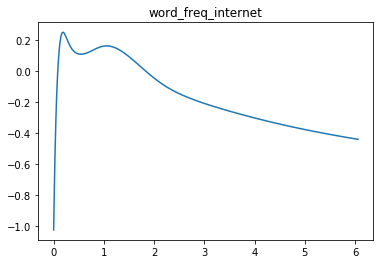

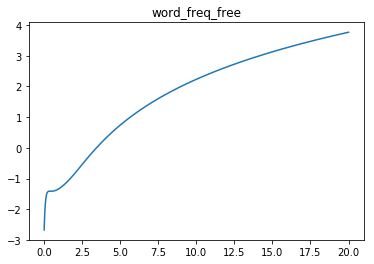

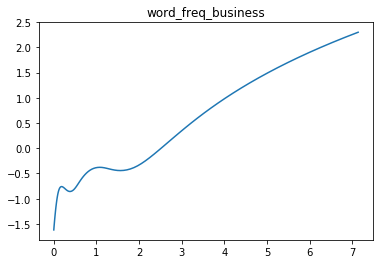

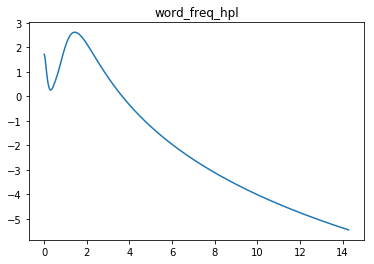

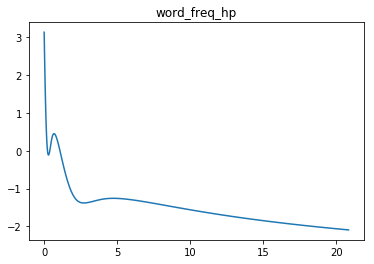

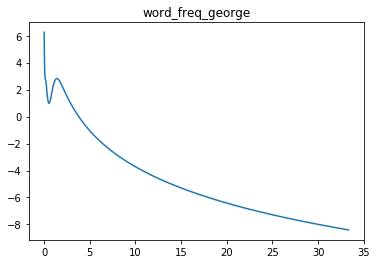

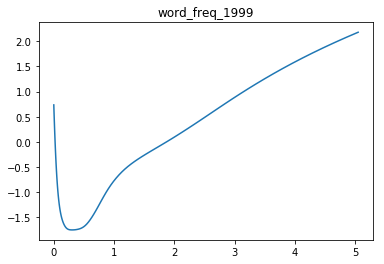

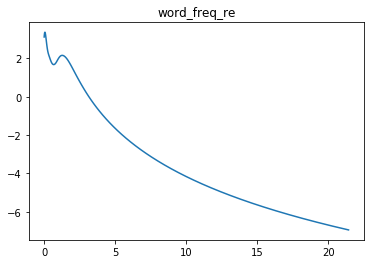

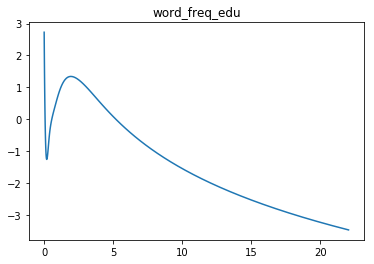

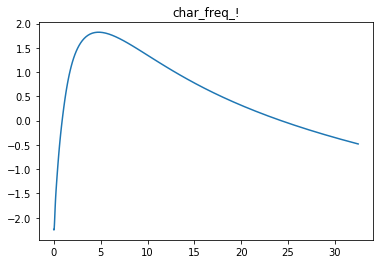

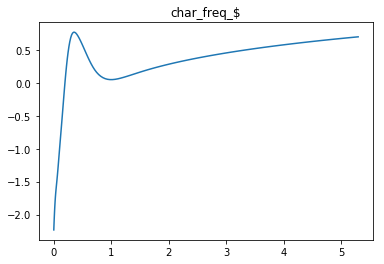

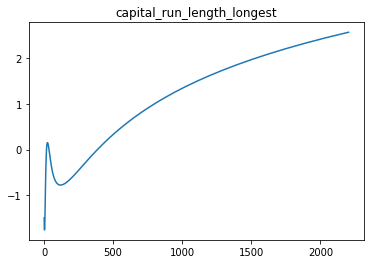

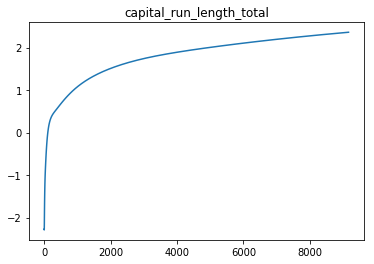

In [9]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    plt.figure()
    plt.plot(np.exp(XX[:, term.feature])-0.1, pdep)
    plt.title(predictors[i])
    plt.show()

In [18]:
clf = tree.DecisionTreeClassifier(max_leaf_nodes=17)
clf.fit(X_train, y_train)
y_test_hat = clf.predict(X_test)

In [19]:
1 - accuracy_score(y_test, y_test_hat)

0.09895833333333337

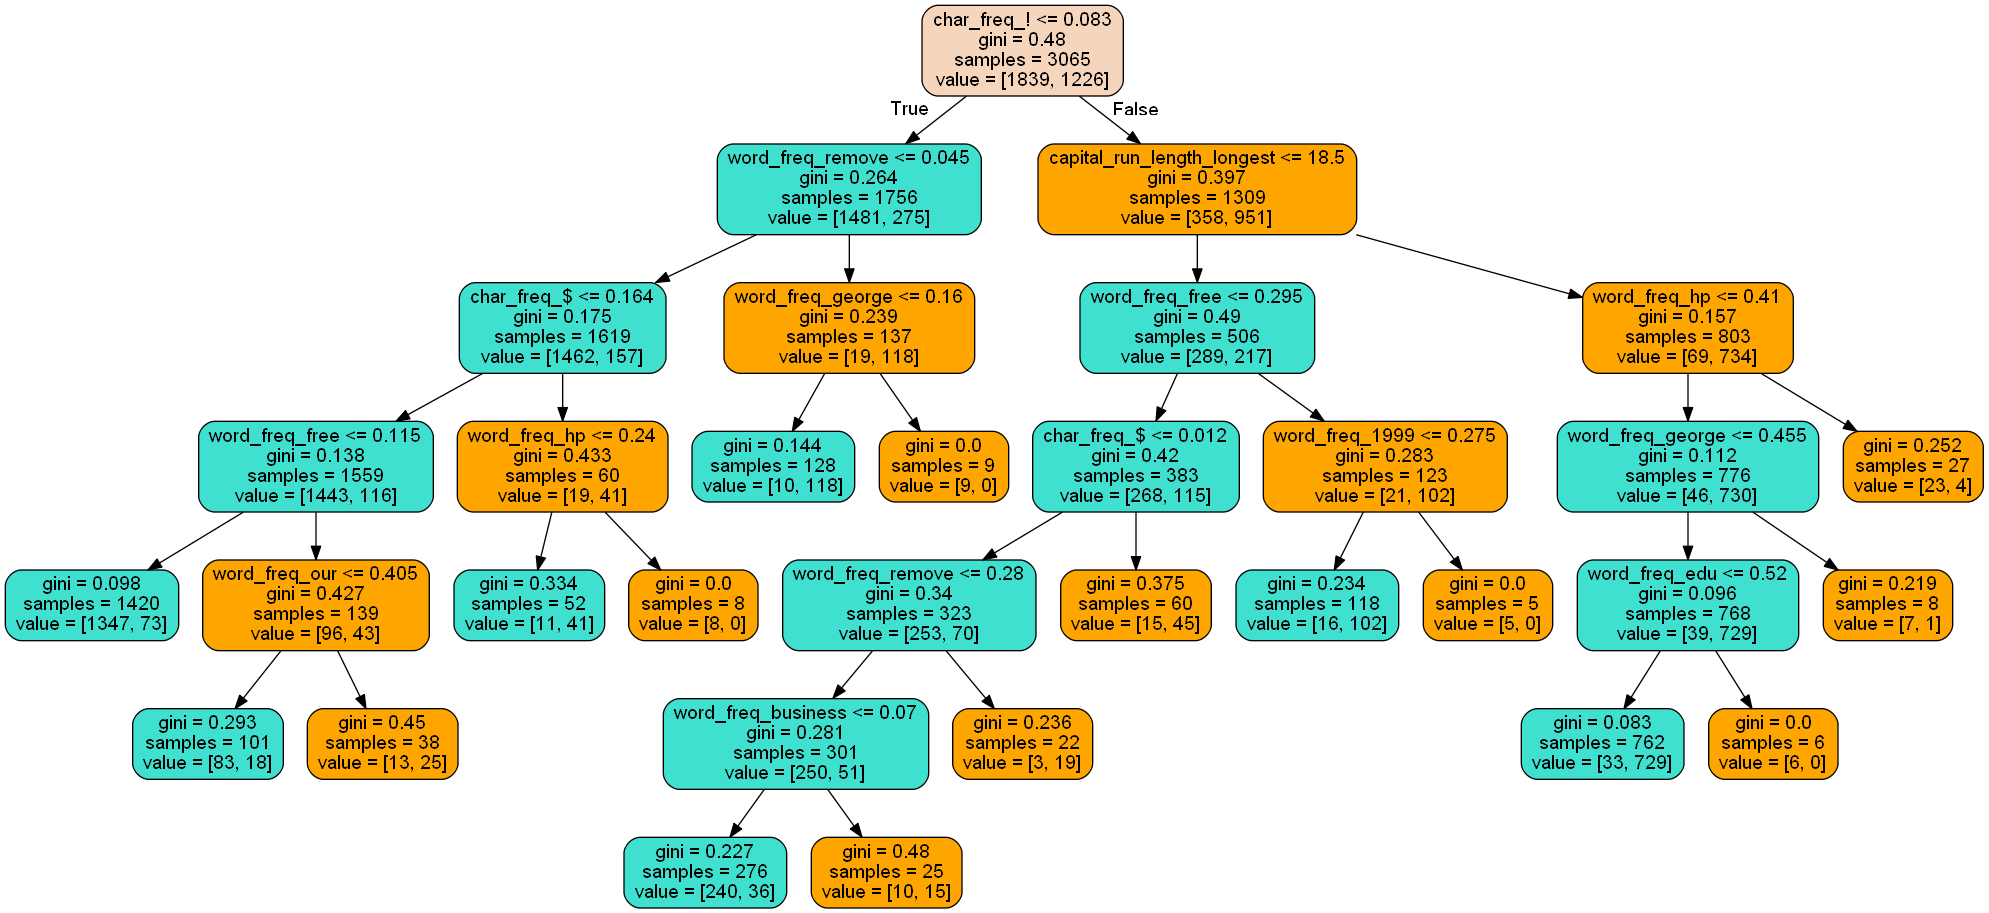

In [20]:
dot_data = tree.export_graphviz(clf,
                                feature_names=predictors,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

display(Image(graph.create_png()))